* **rev 01** Endogenous Models- SARIMA Failed to converge, Prophet looks promising but needs help with area around 2008 and 2020
* **rev 02** Scrape data from EIA.gov api and add Exogenous variables and continue with Prophet model.

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import warnings

# hide warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)

pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)

np.set_printoptions(precision=3)

In [257]:
# load api key
with open('key.txt') as f:
    api_key = f.read()

## Load Data and Inspect

In [258]:
'''Data from: https://www.eia.gov/opendata/qb.php?category=371'''

root_url = f"http://api.eia.gov/series/?api_key={api_key}&series_id="

series_ids = {'NYC_No2_Oil_Price':'PET.EER_EPD2F_PF4_Y35NY_DPG.W',
             'Crude_Oil_Imports':'PET.WCRIMUS2.W',
             'Crude_Oil_Exports':'PET.WCREXUS2.W',
             'US_Fuel_Oil_Imports':'PET.WDIIMUS2.W',
             'US_Fuel_Oil_Exports':'PET.WDIEXUS2.W',
             'US_Supplied':'PET.WRPUPUS2.W'}

In [259]:
import requests
NAME,UNITS,DATA = 0,1,2
# Pull Data
series_pull = dict()
for key in series_ids.keys():
    r = requests.get(root_url + series_ids[key])
    if r.status_code == 200:
        series_pull[key] = [r.json()['series'][0]['name'],
                            r.json()['series'][0]['unitsshort'],
                            r.json()['series'][0]['data']]
        print(f'{key} - data collected successfully...')
    else:
        print(key, f': failed to collect data, status code {r.status_code}')
        
# display series info
print('\nSeries Info:')
for key in series_ids.keys():
    print(series_pull[key][NAME],series_pull[key][UNITS])

NYC_No2_Oil_Price - data collected successfully...
Crude_Oil_Imports - data collected successfully...
Crude_Oil_Exports - data collected successfully...
US_Fuel_Oil_Imports - data collected successfully...
US_Fuel_Oil_Exports - data collected successfully...
US_Supplied - data collected successfully...

Series Info:
New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly $/gal
U.S. Imports of Crude Oil, Weekly Mbbl/d
U.S. Exports of Crude Oil, Weekly Mbbl/d
U.S. Imports of Distillate Fuel Oil, Weekly Mbbl/d
U.S. Exports of Total Distillate, Weekly Mbbl/d
U.S. Product Supplied of Petroleum Products, Weekly Mbbl/d


In [260]:
df = pd.DataFrame(series_pull['NYC_No2_Oil_Price'][DATA],
                  columns=['date',series_pull['NYC_No2_Oil_Price'][NAME]])

x = list(series_pull.keys())
x.remove('NYC_No2_Oil_Price')

for weekly_series in x:
    df = df.merge(pd.DataFrame(series_pull[weekly_series][DATA],
                  columns=['date',series_pull[weekly_series][NAME]]),
                  on='date')

df['date'] = pd.to_datetime(df.date)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 0 to 601
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      602 non-null    datetime64[ns]
 1   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  602 non-null    float64       
 2   U.S. Imports of Crude Oil, Weekly                         602 non-null    int64         
 3   U.S. Exports of Crude Oil, Weekly                         602 non-null    int64         
 4   U.S. Imports of Distillate Fuel Oil, Weekly               602 non-null    int64         
 5   U.S. Exports of Total Distillate, Weekly                  602 non-null    int64         
 6   U.S. Product Supplied of Petroleum Products, Weekly       602 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
me

None

,date,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly"
0,2021-12-10,2.096,6471,3645,450,773,23191
1,2021-12-03,1.957,6499,2270,269,1218,19837
2,2021-11-26,2.223,6604,2704,234,588,20222
3,2021-11-19,2.239,6436,2605,332,1007,21752
4,2021-11-12,2.316,6191,3626,239,849,21629


In [261]:
import pandas_datareader.data as web
import datetime as dt
startYear = 2006
startDate = dt.datetime(startYear,1,1)
endDate = dt.datetime.now()
brn_df = web.DataReader('BRN','yahoo',startDate,endDate)
display(brn_df.info())
#brn_df.plot(subplots = True,legend = True, figsize = (15,15))
# resample as weekly avg
brn_df = brn_df['Adj Close'].resample('W-FRI').mean()
display(brn_df.head())
display(brn_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4019 entries, 2006-01-03 to 2021-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       4019 non-null   float64
 1   Low        4019 non-null   float64
 2   Open       4019 non-null   float64
 3   Close      4019 non-null   float64
 4   Volume     4019 non-null   float64
 5   Adj Close  4019 non-null   float64
dtypes: float64(6)
memory usage: 219.8 KB


None

Date
2006-01-06    22.499
2006-01-13    21.901
2006-01-20    22.410
2006-01-27    23.856
2006-02-03    23.251
Freq: W-FRI, Name: Adj Close, dtype: float64

Date
2021-11-19    2.570
2021-11-26    2.500
2021-12-03    2.420
2021-12-10    2.578
2021-12-17    2.504
Freq: W-FRI, Name: Adj Close, dtype: float64

In [262]:
'''Set Date to index and order in accending time'''
df.set_index('date',inplace = True)
df = df.iloc[::-1]
df = df.join(brn_df, how='left')
df.rename(columns={'Adj Close':'Brent Crude Oil Price, Weekly Avg'},inplace=True)
display(df.info())
display(df.isna().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 602 entries, 2010-06-04 to 2021-12-10
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  602 non-null    float64
 1   U.S. Imports of Crude Oil, Weekly                         602 non-null    int64  
 2   U.S. Exports of Crude Oil, Weekly                         602 non-null    int64  
 3   U.S. Imports of Distillate Fuel Oil, Weekly               602 non-null    int64  
 4   U.S. Exports of Total Distillate, Weekly                  602 non-null    int64  
 5   U.S. Product Supplied of Petroleum Products, Weekly       602 non-null    int64  
 6   Brent Crude Oil Price, Weekly Avg                         602 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 53.8 KB


None

New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly    0
U.S. Imports of Crude Oil, Weekly                           0
U.S. Exports of Crude Oil, Weekly                           0
U.S. Imports of Distillate Fuel Oil, Weekly                 0
U.S. Exports of Total Distillate, Weekly                    0
U.S. Product Supplied of Petroleum Products, Weekly         0
Brent Crude Oil Price, Weekly Avg                           0
dtype: int64

,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly","Brent Crude Oil Price, Weekly Avg"
date,,,,,,,
2010-06-04,1.983,9535,34,236,450,19316,3.248
2010-06-11,1.983,9699,34,270,450,19135,3.062
2010-06-18,2.083,10112,33,171,658,19498,3.270
2010-06-25,2.081,9481,33,183,658,18967,3.106
2010-07-02,1.976,9413,33,297,658,19599,2.892


,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly","Brent Crude Oil Price, Weekly Avg"
date,,,,,,,
2021-11-12,2.316,6191,3626,239,849,21629,2.616
2021-11-19,2.239,6436,2605,332,1007,21752,2.570
2021-11-26,2.223,6604,2704,234,588,20222,2.500
2021-12-03,1.957,6499,2270,269,1218,19837,2.420
2021-12-10,2.096,6471,3645,450,773,23191,2.578


## EDA

In [263]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import UnobservedComponents
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, ccf, pacf

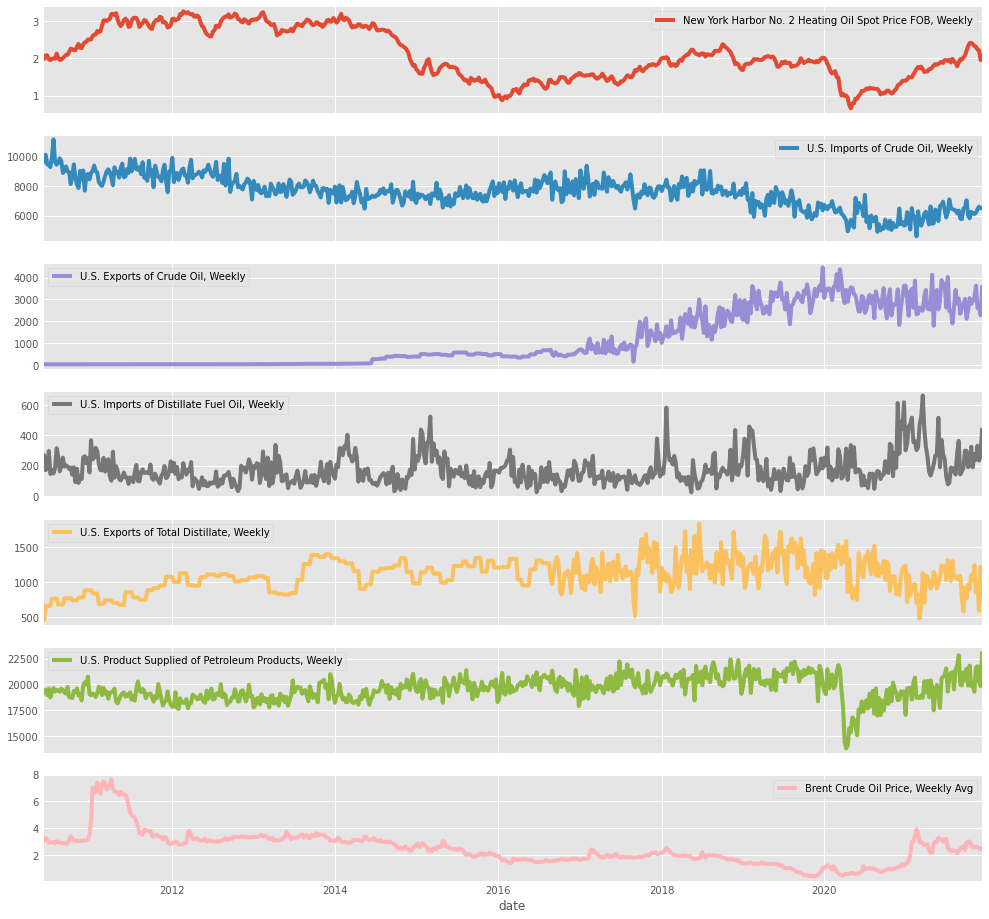

In [264]:
_=df.plot(subplots = True,legend = True, figsize = (15,15))

### Seperate Train, Validation and Remove pre-2012 

In [265]:
df = df.loc['2012':]

In [266]:
n_steps_valid = 52 # save a year for validation
train_df = df.iloc[:-n_steps_valid]
valid_df = df.iloc[-n_steps_valid:]

print(f'Dataset Length: {len(df.index)}')
print(f'Training Set Length: {len(train_df.index)}')
print(f'Validation Set Length: {len(valid_df.index)}')

Dataset Length: 519
Training Set Length: 467
Validation Set Length: 52


In [267]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot

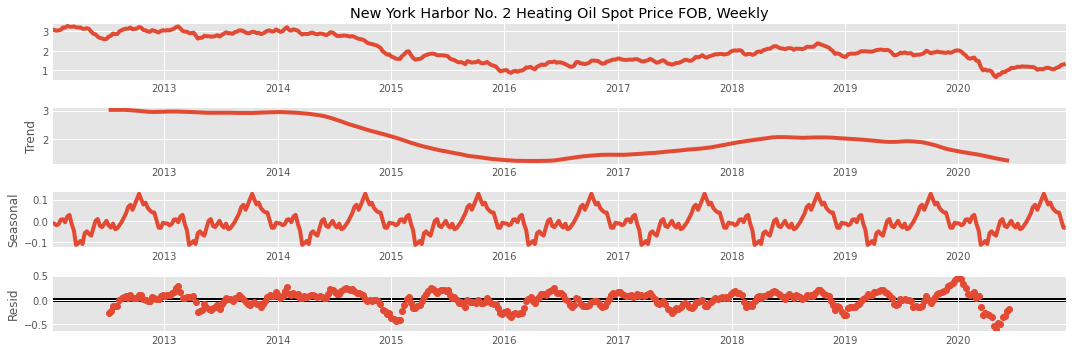

In [268]:
sda = seasonal_decompose(train_df[df.columns[0]],model='additive', period = 52)
_=sda.plot()

In [269]:
from scipy.stats import kstest
def normal_rediuals(data, alpha = 0.05):
    pvalue = kstest(data,'norm').pvalue
    print(f'p-value = {pvalue}')
    if pvalue < alpha:
        # Null is rejected
        print('Null is rejected and the data is not drawn from a normal distribution')
        return False
    else:
        print('Failed to reject the Null; the data is drawn from a normal distribution')
        return True

p-value = 2.7424195032124356e-54
Null is rejected and the data is not drawn from a normal distribution


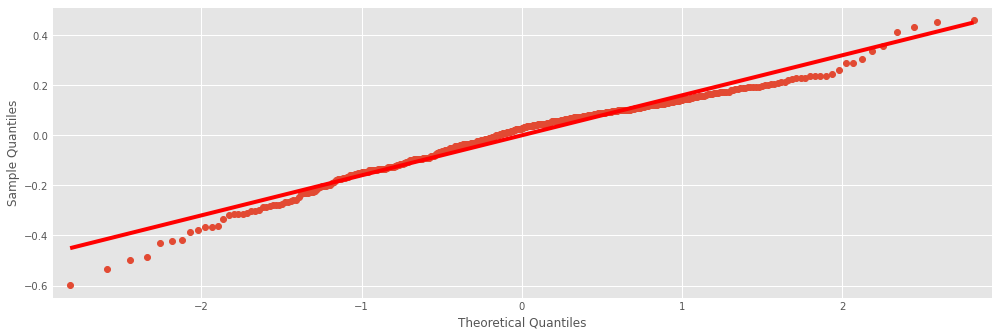

In [270]:
# test residuals
normal_rediuals(sda.resid.dropna())
_=qqplot(sda.resid.dropna(),line='s')

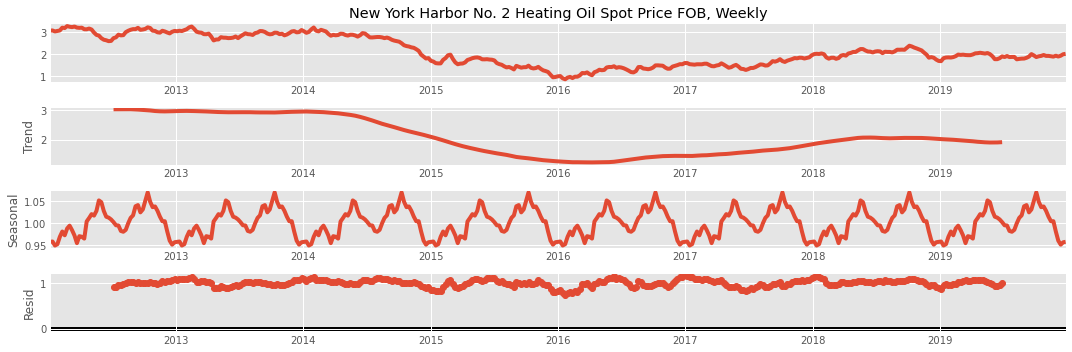

In [271]:
sdm = seasonal_decompose(train_df[df.columns[0]].loc[:'2019'],model='mult', period = 52)
_=sdm.plot()

p-value = 7.40886143245684e-233
Null is rejected and the data is not drawn from a normal distribution


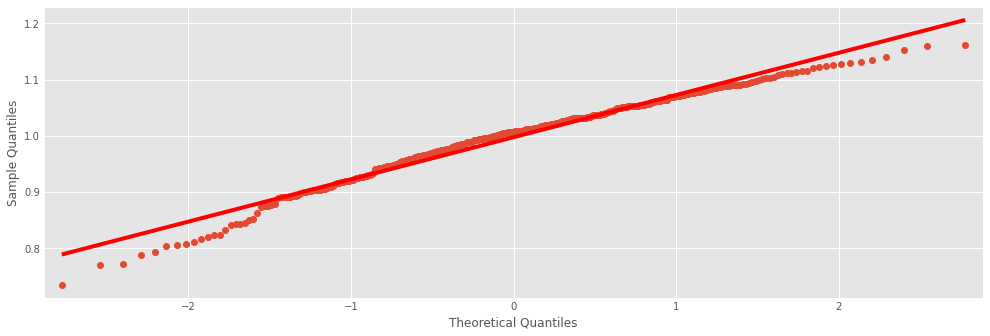

In [272]:
normal_rediuals(sdm.resid.dropna())
_=qqplot(sdm.resid.dropna(),line='s')

### Unobserved component model for eda

In [273]:
levels = [
    'irregular','fixed intercept','deterministic constant',
    'local level','random walk','fixed slope','deterministic trend',
    'local linear deterministic trend','random walk with drift',
    'local linear trend','smooth trend','random trend'
         ]
model = {
    'level':None,
    'cycle':False,
    'seasonal':None
}

for level in levels:
    model['level'] = level
    uc_model = UnobservedComponents(train_df[df.columns[0]], **model)
    uc_res = uc_model.fit()
    print(f'{level}, AIC = {uc_res.aic}')


irregular, AIC = 2039.6690035955744
fixed intercept, AIC = 991.0932920403947
deterministic constant, AIC = 991.0932920403947
local level, AIC = -1252.182722028108
random walk, AIC = -1254.1827237681348
fixed slope, AIC = 670.8064005089753
deterministic trend, AIC = 670.8064005089753
local linear deterministic trend, AIC = -1243.9703262872204
random walk with drift, AIC = -1245.9703280338945
local linear trend, AIC = -1241.7719886847067
smooth trend, AIC = -1144.3185322619634
random trend, AIC = -1090.9143374597916


In [274]:
for level in ['random walk','local level']:
    for cycle in [True,False]:
        for season in [None,52]:
            model = {'level':level,'cycle':cycle,'seasonal':season}
            uc_model = UnobservedComponents(train_df[df.columns[0]],**model)
            uc_res = uc_model.fit()
            print(f'{[level,cycle,season]}, AIC = {uc_res.aic}')
                

['random walk', True, None], AIC = -1241.5232438789471
['random walk', True, 52], AIC = 625.2636914123968
['random walk', False, None], AIC = -1254.1827237681348
['random walk', False, 52], AIC = -1004.0575115524832
['local level', True, None], AIC = -1239.5232419510226
['local level', True, 52], AIC = 642.3086517820249
['local level', False, None], AIC = -1252.182722028108
['local level', False, 52], AIC = -1002.057502216094


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           Unobserved Components Results                                            
====================================================================================================================
Dep. Variable:     New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly   No. Observations:                  467
Model:                                                          random walk   Log Likelihood                 628.091
Date:                                                      Fri, 17 Dec 2021   AIC                          -1254.183
Time:                                                              10:03:16   BIC                          -1250.039
Sample:                                                          01-06-2012   HQIC                         -1252.552
                                                               - 12-11-2020                                         
Covariance Type:                                                        opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     0.0040      0.000     19.625      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                  40.11   Jarque-Bera (JB):                40.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.38
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

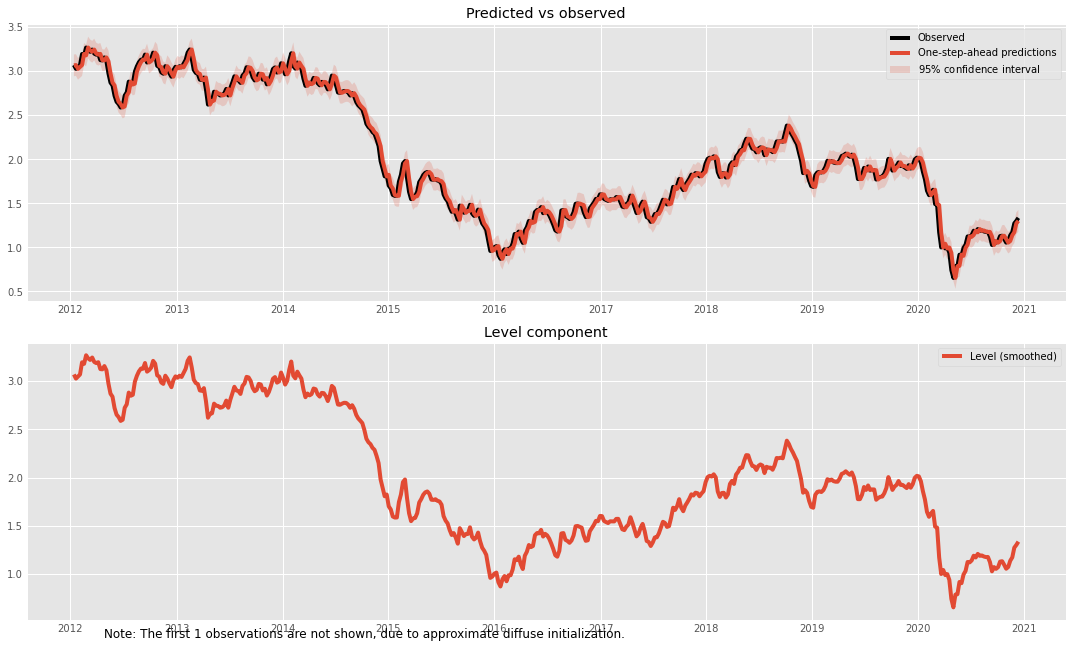

In [275]:
model = {
    'level':'random walk',
    'cycle':False,
    'seasonal':None
}
uc_model = UnobservedComponents(train_df[df.columns[0]], **model)
uc_res = uc_model.fit()
display(uc_res.summary())

fig = uc_res.plot_components(legend_loc='best', figsize=(15,9))
plt.tight_layout()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           Unobserved Components Results                                            
====================================================================================================================
Dep. Variable:     New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly   No. Observations:                  467
Model:                                                          local level   Log Likelihood                 628.091
Date:                                                      Fri, 17 Dec 2021   AIC                          -1252.183
Time:                                                              10:03:17   BIC                          -1243.894
Sample:                                                          01-06-2012   HQIC                         -1248.921
                                                               - 12-11-2020                                         
Covariance Type:                                                        opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    2.5e-11      0.000   1.54e-07      1.000      -0.000       0.000
sigma2.level         0.0040      0.000     12.183      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                  40.11   Jarque-Bera (JB):                40.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.38
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

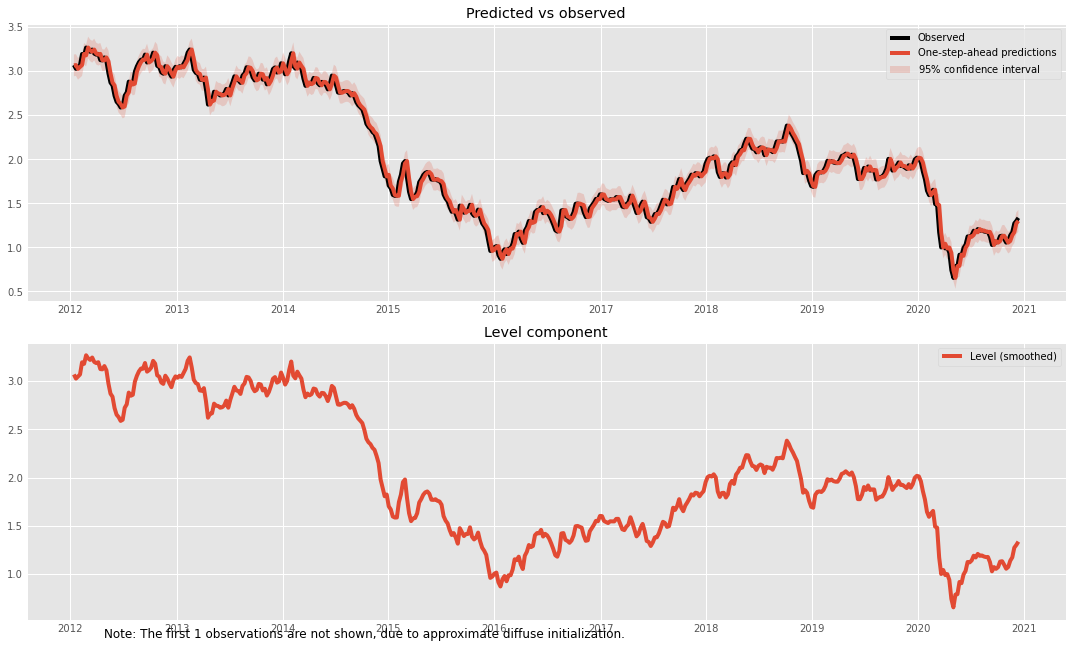

In [276]:
model = {
    'level':'local level',
    'cycle':False,
    'seasonal':None
}
uc_model = UnobservedComponents(train_df[df.columns[0]], **model)
uc_res = uc_model.fit()
display(uc_res.summary())

fig = uc_res.plot_components(legend_loc='best', figsize=(15,9))
plt.tight_layout()

In [325]:
predict_res = uc_res.get_forecast(n_steps_valid)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

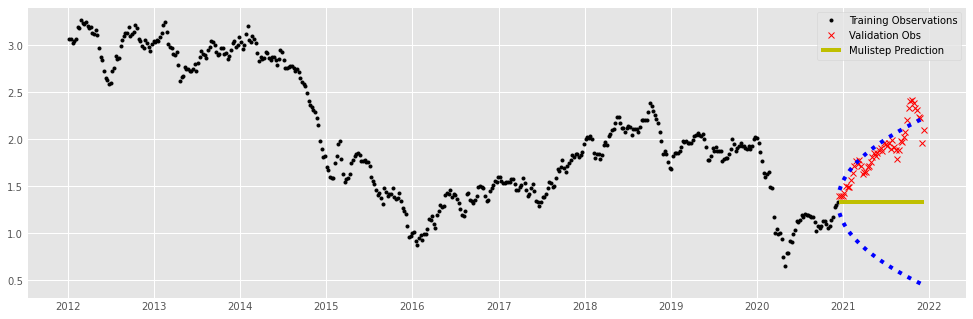

In [330]:
fig,ax = plt.subplots()
# plot results
ax.plot(train_df[train_df.columns[0]], 'k.',label='Training Observations')
ax.plot(valid_df[train_df.columns[0]], 'rx',label='Validation Obs')

ax.plot(valid_df.index, predict, 'y', label='Mulistep Prediction')
ax.plot(valid_df.index, ci, 'b:')

legend = ax.legend(loc='best')

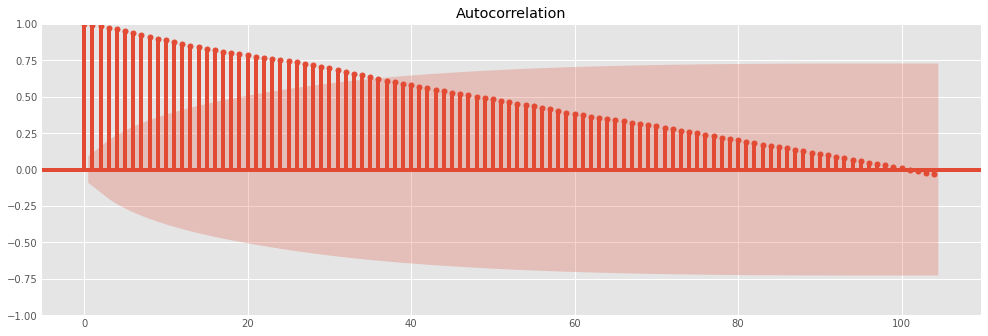

In [277]:
_=plot_acf(train_df[df.columns[0]],lags=104)

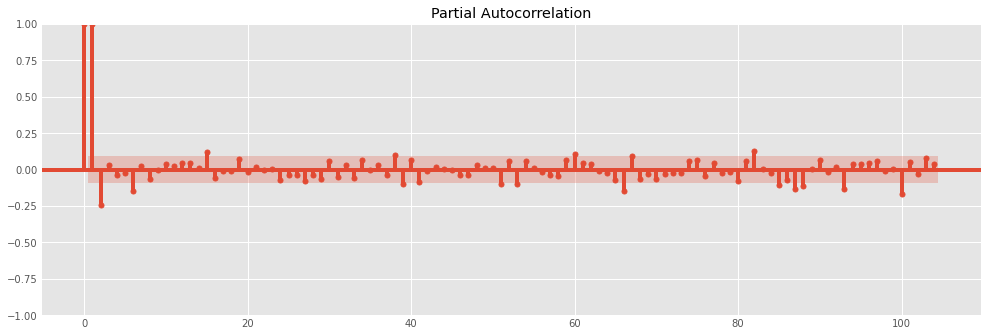

In [278]:
_=plot_pacf(train_df[df.columns[0]],lags=104)

#### Conclusion
No seasonality is present in target variable

## Examine Data for Granger Causality

In [279]:
y = df.columns[0]
X = df.columns[1:]
for x in X:
    
    # The data for test whether the time series in the second column
    # Granger causes the time series in the first column.

    print('='*50)
    print(f'{x}')
    print('='*50)
    print('Granger Test Results')
    u = grangercausalitytests(df[[y,x]].values,maxlag=16)    

U.S. Imports of Crude Oil, Weekly
Granger Test Results

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1689  , p=0.6813  , df_denom=515, df_num=1
ssr based chi2 test:   chi2=0.1699  , p=0.6802  , df=1
likelihood ratio test: chi2=0.1698  , p=0.6803  , df=1
parameter F test:         F=0.1689  , p=0.6813  , df_denom=515, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3846  , p=0.6809  , df_denom=512, df_num=2
ssr based chi2 test:   chi2=0.7767  , p=0.6782  , df=2
likelihood ratio test: chi2=0.7761  , p=0.6784  , df=2
parameter F test:         F=0.3846  , p=0.6809  , df_denom=512, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3942  , p=0.7572  , df_denom=509, df_num=3
ssr based chi2 test:   chi2=1.1988  , p=0.7533  , df=3
likelihood ratio test: chi2=1.1975  , p=0.7536  , df=3
parameter F test:         F=0.3942  , p=0.7572  , df_denom=509, df_num=3

Granger Causality
number of lags (no z

ssr based F test:         F=0.5727  , p=0.8961  , df_denom=473, df_num=15
ssr based chi2 test:   chi2=9.1534  , p=0.8694  , df=15
likelihood ratio test: chi2=9.0713  , p=0.8738  , df=15
parameter F test:         F=0.5727  , p=0.8961  , df_denom=473, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=0.6745  , p=0.8200  , df_denom=470, df_num=16
ssr based chi2 test:   chi2=11.5499 , p=0.7743  , df=16
likelihood ratio test: chi2=11.4193 , p=0.7829  , df=16
parameter F test:         F=0.6745  , p=0.8200  , df_denom=470, df_num=16
U.S. Imports of Distillate Fuel Oil, Weekly
Granger Test Results

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2418  , p=0.6231  , df_denom=515, df_num=1
ssr based chi2 test:   chi2=0.2432  , p=0.6219  , df=1
likelihood ratio test: chi2=0.2431  , p=0.6220  , df=1
parameter F test:         F=0.2418  , p=0.6231  , df_denom=515, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:   

ssr based F test:         F=0.6831  , p=0.7917  , df_denom=476, df_num=14
ssr based chi2 test:   chi2=10.1460 , p=0.7514  , df=14
likelihood ratio test: chi2=10.0455 , p=0.7589  , df=14
parameter F test:         F=0.6831  , p=0.7917  , df_denom=476, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=0.7431  , p=0.7406  , df_denom=473, df_num=15
ssr based chi2 test:   chi2=11.8770 , p=0.6883  , df=15
likelihood ratio test: chi2=11.7392 , p=0.6987  , df=15
parameter F test:         F=0.7431  , p=0.7406  , df_denom=473, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=0.7827  , p=0.7059  , df_denom=470, df_num=16
ssr based chi2 test:   chi2=13.4020 , p=0.6432  , df=16
likelihood ratio test: chi2=13.2266 , p=0.6561  , df=16
parameter F test:         F=0.7827  , p=0.7059  , df_denom=470, df_num=16
U.S. Product Supplied of Petroleum Products, Weekly
Granger Test Results

Granger Causality
number of lags (no zero) 1
ssr bas

likelihood ratio test: chi2=19.1305 , p=0.2620  , df=16
parameter F test:         F=1.1387  , p=0.3158  , df_denom=470, df_num=16


==================================================

U.S. Imports of Distillate Fuel Oil, Weekly

==================================================

number of lags (no zero) 8
ssr based F test:         F=1.9862  , p=0.0460  , df_denom=576, df_num=8
ssr based chi2 test:   chi2=16.3585 , p=0.0375  , df=8
likelihood ratio test: chi2=16.1369 , p=0.0405  , df=8
parameter F test:         F=1.9862  , p=0.0460  , df_denom=576, df_num=8


==================================================

U.S. Exports of Total Distillate, Weekly

==================================================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=9.0125  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9455  , p=0.0028  , df=1
parameter F test:         F=8.9674  , p=0.0029  , df_denom=597, df_num=

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2
ssr based chi2 test:   chi2=6.3073  , p=0.0427  , df=2
likelihood ratio test: chi2=6.2743  , p=0.0434  , df=2
parameter F test:         F=3.1273  , p=0.0446  , df_denom=594, df_num=2


==================================================

Brent Crude Oil Price, Weekly Avg

==================================================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1567  , p=0.0077  , df_denom=597, df_num=1
ssr based chi2 test:   chi2=7.1927  , p=0.0073  , df=1
likelihood ratio test: chi2=7.1499  , p=0.0075  , df=1
parameter F test:         F=7.1567  , p=0.0077  , df_denom=597, df_num=1


## Try Prophet

In [340]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

model = Prophet()

In [341]:
train_df.reset_index().columns
exogenous_vars = ['U.S. Imports of Distillate Fuel Oil, Weekly',
                  'U.S. Exports of Total Distillate, Weekly',
                  'Brent Crude Oil Price, Weekly Avg']

In [343]:
ptrain_df = train_df.reset_index().rename(columns={'date':'ds',
                                                   'New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly':'y'})
for exo in exogenous_vars:
    model.add_regressor(exo)
model.fit(ptrain_df[['ds','y']+exogenous_vars])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [347]:
pred_df = model.make_future_dataframe(periods=52,freq='W-FRI')
for exo in exogenous_vars:
    pred_df[exo] = df[exo].values
p_forcast = model.predict(pred_df)
#p_forcast = model.predict(pred_df[['ds','y']])
p_forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Brent Crude Oil Price, Weekly Avg","Brent Crude Oil Price, Weekly Avg_lower","Brent Crude Oil Price, Weekly Avg_upper","U.S. Exports of Total Distillate, Weekly","U.S. Exports of Total Distillate, Weekly_lower","U.S. Exports of Total Distillate, Weekly_upper","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly_lower","U.S. Imports of Distillate Fuel Oil, Weekly_upper",additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-06,2.857,2.817,3.261,2.857,2.857,0.177,0.177,0.177,-0.011,-0.011,-0.011,-4.911e-04,-4.911e-04,-4.911e-04,0.166,0.166,0.166,0.165,0.165,0.165,8.058e-04,8.058e-04,8.058e-04,0.0,0.0,0.0,3.023
1,2012-01-13,2.855,2.793,3.236,2.855,2.855,0.192,0.192,0.192,-0.020,-0.020,-0.020,-1.473e-02,-1.473e-02,-1.473e-02,0.159,0.159,0.159,0.158,0.158,0.158,1.820e-03,1.820e-03,1.820e-03,0.0,0.0,0.0,3.015
2,2012-01-20,2.853,2.809,3.260,2.853,2.853,0.205,0.205,0.205,-0.020,-0.020,-0.020,3.831e-03,3.831e-03,3.831e-03,0.185,0.185,0.185,0.188,0.188,0.188,-3.328e-03,-3.328e-03,-3.328e-03,0.0,0.0,0.0,3.038
3,2012-01-27,2.851,2.780,3.227,2.851,2.851,0.192,0.192,0.192,-0.020,-0.020,-0.020,-7.864e-03,-7.864e-03,-7.864e-03,0.156,0.156,0.156,0.164,0.164,0.164,-7.639e-03,-7.639e-03,-7.639e-03,0.0,0.0,0.0,3.007
4,2012-02-03,2.849,2.773,3.222,2.849,2.849,0.158,0.158,0.158,-0.020,-0.020,-0.020,1.273e-02,1.273e-02,1.273e-02,0.152,0.152,0.152,0.151,0.151,0.151,7.947e-04,7.947e-04,7.947e-04,0.0,0.0,0.0,3.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2021-11-12,0.954,0.781,1.312,0.799,1.092,0.117,0.117,0.117,-0.038,-0.038,-0.038,-1.981e-02,-1.981e-02,-1.981e-02,0.108,0.108,0.108,0.060,0.060,0.060,4.809e-02,4.809e-02,4.809e-02,0.0,0.0,0.0,1.062
515,2021-11-19,0.945,0.755,1.302,0.784,1.087,0.107,0.107,0.107,-0.019,-0.019,-0.019,-4.346e-02,-4.346e-02,-4.346e-02,0.097,0.097,0.097,0.044,0.044,0.044,5.266e-02,5.266e-02,5.266e-02,0.0,0.0,0.0,1.042
516,2021-11-26,0.936,0.703,1.261,0.770,1.083,0.090,0.090,0.090,-0.068,-0.068,-0.068,-1.854e-02,-1.854e-02,-1.854e-02,0.054,0.054,0.054,0.003,0.003,0.003,5.104e-02,5.104e-02,5.104e-02,0.0,0.0,0.0,0.991
517,2021-12-03,0.927,0.720,1.289,0.755,1.080,0.071,0.071,0.071,0.006,0.006,0.006,-2.744e-02,-2.744e-02,-2.744e-02,0.087,0.087,0.087,0.050,0.050,0.050,3.743e-02,3.743e-02,3.743e-02,0.0,0.0,0.0,1.014


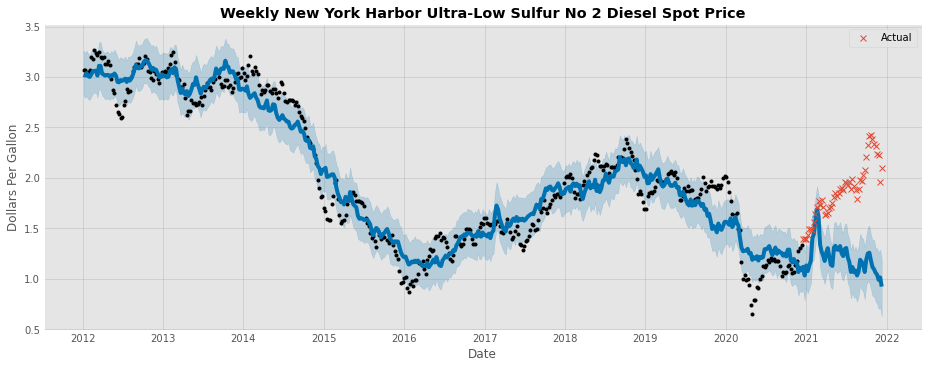

In [348]:
fig = model.plot(p_forcast,figsize=(13,5))
ax = fig.gca()
ax.plot(valid_df.index,valid_df[valid_df.columns[0]],'x',label='Actual')
ax.legend(loc='best')
ax.set_title('Weekly New York Harbor Ultra-Low Sulfur No 2 Diesel Spot Price',
         fontweight='bold')
ax.set_ylabel('Dollars Per Gallon')
_=ax.set_xlabel('Date')

## VAR Model

In [285]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [286]:
var_vars = ['New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly'] + exogenous_vars
var_model = VAR(train_df[var_vars])

In [287]:
vms_res = var_model.select_order(5)
vms_res.summary()

,AIC,BIC,FPE,HQIC
0,17.38,17.42,3.535e+07,17.39
1,8.940,9.119,7633.,9.011
2,8.728*,9.051*,6176.*,8.855*
3,8.735,9.201,6218.,8.918
4,8.772,9.381,6454.,9.012
5,8.805,9.557,6671.,9.101


In [288]:
var_res = var_model.fit(2)

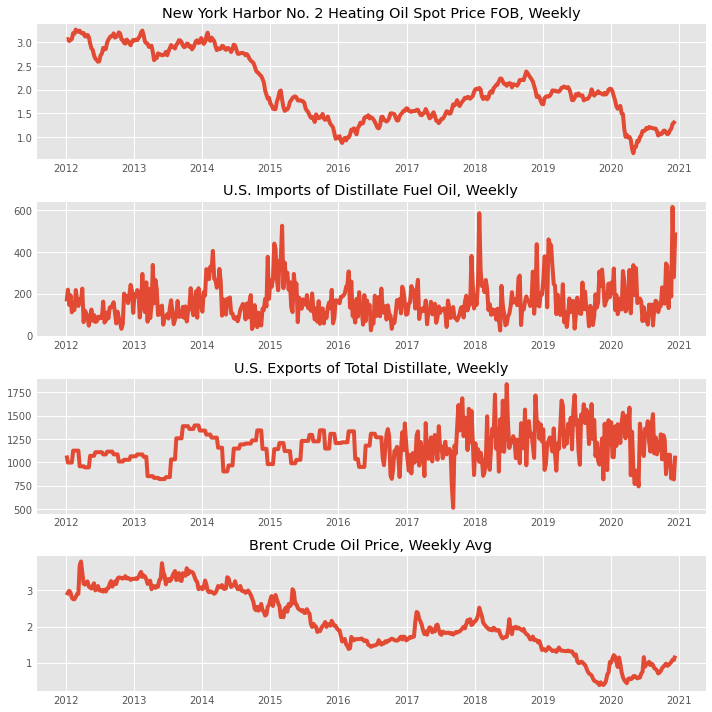

In [289]:
_=var_res.plot()
plt.tight_layout()

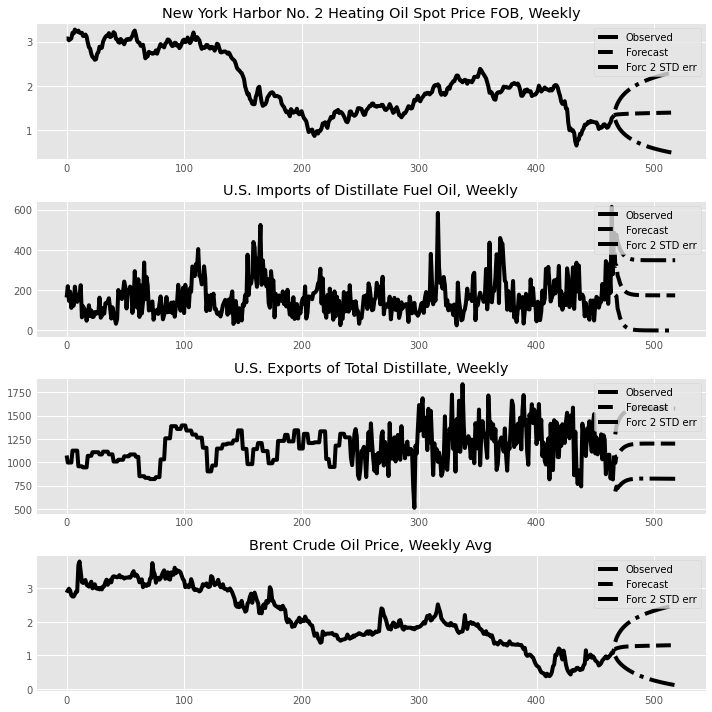

In [290]:
fig = var_res.plot_forecast(n_steps_valid)
plt.tight_layout()

## ARIMAX Model


In [291]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarimax_exog_res = SARIMAX(train_df[var_vars[0]], exog=train_df[var_vars[1:]], order=(2, 1, 0)).fit()

In [292]:
sarimax_exog_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                  SARIMAX Results                                                   
====================================================================================================================
Dep. Variable:     New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly   No. Observations:                  467
Model:                                                     SARIMAX(2, 1, 0)   Log Likelihood                 650.129
Date:                                                      Fri, 17 Dec 2021   AIC                          -1288.259
Time:                                                              10:03:27   BIC                          -1263.394
Sample:                                                          01-06-2012   HQIC                         -1278.473
                                                               - 12-11-2020                                         
Covariance Type:                                                        opg                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
U.S. Imports of Distillate Fuel Oil, Weekly  5.068e-06   2.56e-05      0.198      0.843   -4.51e-05    5.52e-05
U.S. Exports of Total Distillate, Weekly    -7.083e-07   1.27e-05     -0.056      0.956   -2.57e-05    2.43e-05
Brent Crude Oil Price, Weekly Avg               0.0427      0.030      1.424      0.154      -0.016       0.101
ar.L1                                           0.3026      0.048      6.277      0.000       0.208       0.397
ar.L2                                          -0.0523      0.039     -1.327      0.184      -0.129       0.025
sigma2                                          0.0036      0.000     20.013      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                55.70
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.32
Prob(H) (two-sided):                  0.71   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [293]:
sarimax_for = sarimax_exog_res.get_forecast(n_steps_valid,exog=valid_df[exogenous_vars])

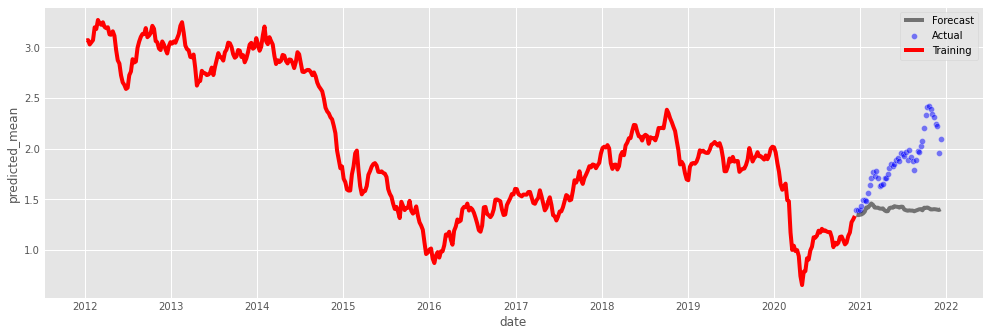

In [316]:
ax = sns.lineplot(valid_df.index,sarimax_for.predicted_mean,label='Forecast',color='k',alpha=0.5)
sns.scatterplot(valid_df.index,valid_df[valid_df.columns[0]],label='Actual',color='b',ax=ax,alpha=0.5)
_=sns.lineplot(train_df.index, train_df[train_df.columns[0]], label='Training',color='r', ax=ax)